# Implementation of baseline for DANN
Reference: https://arxiv.org/pdf/1505.07818.pdf

In [5]:
import torch
import torchvision
import torch.nn as nn

In [6]:
torch.__version__

'2.5.1'

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [8]:
import numpy as np
import datetime
import os, sys

In [9]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(1)

In [11]:
MODEL_NAME = 'NN'
print("cuda") if torch.cuda.is_available() else print("cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [12]:
import torch
print(torch.version.cuda)      # Should print CUDA version (e.g., '12.1')
print(torch.cuda.is_available())  # Should print True if CUDA is usable
print(torch.cuda.device_count())  # Number of GPUs detected
print(torch.cuda.get_device_name(0))  # GPU model name (if available)


12.1
True
1
NVIDIA RTX A5000


In [13]:
import torch
print("CUDA available?", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "No CUDA")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)


CUDA available? True
Current device: 0
Device name: NVIDIA RTX A5000
DEVICE = cuda


In [14]:
print("cuda") if torch.cuda.is_available() else print("cpu")


cuda


In [15]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [16]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, h):
        c = self.layer(h)
        return c

In [17]:
F = FeatureExtractor().to(DEVICE)
C = Classifier().to(DEVICE)

In [18]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

In [19]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

In [20]:
svhn_train = datasets.SVHN(root='../data/', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='../data/', split='test', transform=transform, download=True)

Using downloaded and verified file: ../data/train_32x32.mat
Using downloaded and verified file: ../data/test_32x32.mat


In [21]:
batch_size = 64

In [22]:
svhn_train.data.shape

(73257, 3, 32, 32)

In [23]:
svhn_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
eval_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [24]:
xe = nn.CrossEntropyLoss()

In [25]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())

In [26]:
max_epoch = 50
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mnist_train)//batch_size
# lamda = 0.01

### Training Code



In [27]:
mnist_set = iter(mnist_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    if step % n_batches == 0:
        mnist_set = iter(mnist_loader)
    return next(mnist_set)

In [28]:
ll_c = []
acc_lst = []

In [29]:
for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)
        # Training Discriminator
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)
        
        c = C(F(src))
        Lc = xe(c, labels)
        
        F.zero_grad()
        C.zero_grad()
        
        Lc.backward()
        
        C_opt.step()
        F_opt.step()
        
        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, C Loss: {:.4f} ---- {}'.format(epoch, max_epoch, step, Lc.item(), dt))
            ll_c.append(Lc)
        
        if step % 500 == 0:
            F.eval()
            C.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(eval_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = C(F(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(eval_loader.dataset)
                print('***** Eval Result: {:.4f}, Step: {}'.format(acc, step))
                
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(test_loader):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = C(F(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader.dataset)
                print('***** Test Result: {:.4f}, Step: {}'.format(acc, step))
                acc_lst.append(acc)
                
            F.train()
            C.train()
        step += 1

Epoch: 1/50, Step: 0, C Loss: 2.3197 ---- 11:20:01
***** Eval Result: 0.1040, Step: 0
***** Test Result: 0.1135, Step: 0
Epoch: 1/50, Step: 100, C Loss: 2.1457 ---- 11:20:11
Epoch: 1/50, Step: 200, C Loss: 1.8396 ---- 11:20:14
Epoch: 1/50, Step: 300, C Loss: 1.8614 ---- 11:20:17
Epoch: 1/50, Step: 400, C Loss: 2.0076 ---- 11:20:20
Epoch: 1/50, Step: 500, C Loss: 1.5553 ---- 11:20:23
***** Eval Result: 0.3695, Step: 500
***** Test Result: 0.2506, Step: 500
Epoch: 1/50, Step: 600, C Loss: 1.3982 ---- 11:20:31
Epoch: 1/50, Step: 700, C Loss: 1.4812 ---- 11:20:35
Epoch: 1/50, Step: 800, C Loss: 1.2108 ---- 11:20:38
Epoch: 1/50, Step: 900, C Loss: 1.0611 ---- 11:20:41
Epoch: 1/50, Step: 1000, C Loss: 1.3106 ---- 11:20:44
***** Eval Result: 0.4951, Step: 1000
***** Test Result: 0.2243, Step: 1000
Epoch: 1/50, Step: 1100, C Loss: 1.0030 ---- 11:20:53
Epoch: 2/50, Step: 1200, C Loss: 0.7546 ---- 11:20:55
Epoch: 2/50, Step: 1300, C Loss: 0.8485 ---- 11:20:58
Epoch: 2/50, Step: 1400, C Loss: 0.9

## Visualize Sample

In [30]:
import matplotlib.pyplot as plt

/tmp/ipykernel_170621/4071226408.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


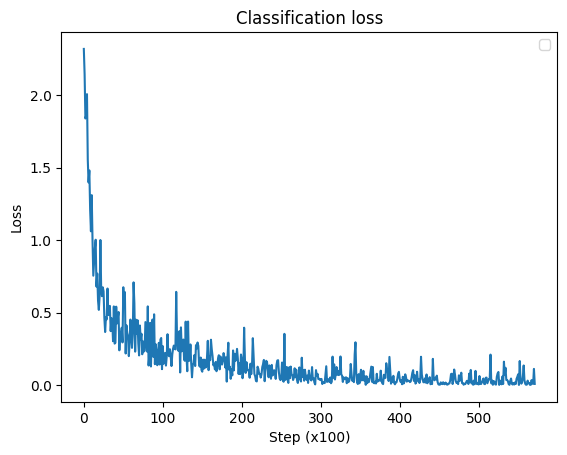

In [36]:
import matplotlib.pyplot as plt

# Convert CUDA tensors to CPU floats for plotting
ll_c_cpu = [x.cpu().item() if torch.is_tensor(x) else x for x in ll_c]

# Plotting
plt.plot(range(len(ll_c_cpu)), ll_c_cpu)
plt.xlabel("Step (x100)")
plt.ylabel("Loss")
plt.title("Classification loss")
plt.legend()
plt.show()


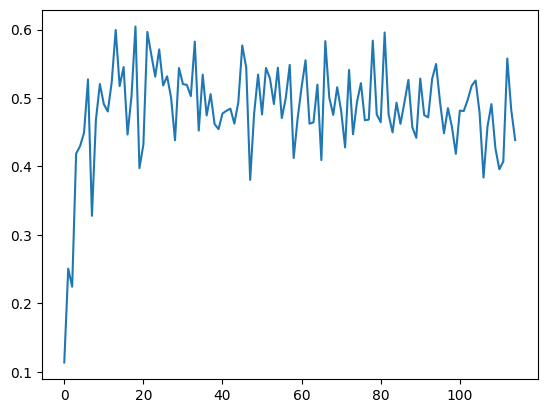

In [35]:
plt.plot(range(len(acc_lst)), acc_lst)

In [34]:
max(acc_lst)

0.6045